# PCA Analysis

**Abstract:**
One-sentence description

**Description:**
In the following cell, I...


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys
import os

sys.path.append("..")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'

from config import SCHEME_87, ROOT
os.chdir(ROOT)

/Users/songshgeo/opt/anaconda3/envs/WAInstitution_YRB_2021/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from core.datasets import Datasets

dataset = Datasets(unit_base='data', name='filter_features')

dataset.add_item_from_file(
    rel_path="processed/merged_data.csv",
    name='merged',
    description='Merged: Zhou WU, GDP data, and Natural data',
    index_col=0,
)


province_mean = dataset.merged.obj.groupby('Province').mean().dropna(how='any')

dataset.add_item_from_dataframe(
    data=province_mean,
    name='province_mean',
    category='assets',
    rel_path_folder="processed",
    save=True,
    description='Mean, dropna=any.'
)

dataset.report()

+---------------+--------------------------------+--------------------------------+----------+
|      Name     |          Description           |              Path              | Category |
+---------------+--------------------------------+--------------------------------+----------+
|     merged    | Merged: Zhou WU, GDP data, and |   data/processed/merged.csv    |  assets  |
|               |          Natural data          |                                |          |
| province_mean |       Mean, dropna=any.        | data/processed/province_mean.c |  assets  |
|               |                                |               sv               |          |
+---------------+--------------------------------+--------------------------------+----------+


In [3]:
from core.model import Method
from core.src.filter_features import fit_pca, transform_features
import yaml
from core.analysis import Analyst

os.chdir(ROOT)
YAML_PATH = "model/normalized_87.yaml"
with open(YAML_PATH, "r", encoding="utf-8") as file:
    params = yaml.load(file.read(), Loader=yaml.FullLoader)
    file.close()

features = params.get("parameters")['X_inputs']
features.remove("Province")
features.remove("Year")
features.remove("Total water use")

methods = Method(unit_base='model', name='filter_features')
analyst = Analyst(unit_base="content", name='filter_features')

pca_transform = methods.add_function_item(
        name=f"pca_transform",
        function=transform_features,
        description=f"Transform features by fitted model",
        parameters={
            'features': features,
            'normalize': True
        }
    )

pca_transform = analyst.add_analyst_item(
        name=f"pca_transform",
        description=f"Transform features by fitted model",
        data_item=dataset.merged,
        method_item=pca_transform
    )

models = []
for n_components in (0.85, 0.95):
    method_item = methods.add_function_item(
        name=f"pca_fit_{n_components}",
        function=fit_pca,
        description=f"all features without GDP, n_components={n_components}%, normalize=True.",
        parameters={
            'features': features,
            'n_components': n_components,
            'normalize': True
        }
    )
    
    analyst_item = analyst.add_analyst_item(
        name=f"pca_{n_components}",
        description='Fit a PCA model by mean province merged data.',
        data_item=dataset.province_mean,
        method_item=method_item,
    )
    
    result = analyst_item.do_analysis()
    model = result[0]
    models.append(model)
    transformed_data = analyst.pca_transform.do_analysis(fitted_model=model)

    transformed_data = dataset.add_item_from_dataframe(
        transformed_data,
        name=f'pca_transformed_{n_components}',
        category='assets',
        rel_path_folder='processed',
        save=True,
    )

methods.path
methods.report()
dataset.report()

[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [85.0%] explained variance using the [24] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [85.00%] explained variance.
[pca] >The PCA reduction is performed on the [24] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [24] columns of the input data.
[pca] >Fit u

'/Users/songshgeo/Documents/Pycharm/WAInstitution_YRB_2021/model'

+---------------+--------------------------------+--------------------+--------------------------------+
|      Name     |          Description           |        Func        |             Params             |
+---------------+--------------------------------+--------------------+--------------------------------+
| pca_transform |  Transform features by fitted  | transform_features |  (1) features.(2) normalize.   |
|               |             model              |                    |                                |
|  pca_fit_0.85 |   all features without GDP,    |      fit_pca       |        (1) features.(2)        |
|               |      n_components=0.85%,       |                    |  n_components.(3) normalize.   |
|               |        normalize=True.         |                    |                                |
|  pca_fit_0.95 |   all features without GDP,    |      fit_pca       |        (1) features.(2)        |
|               |      n_components=0.95%,       |     

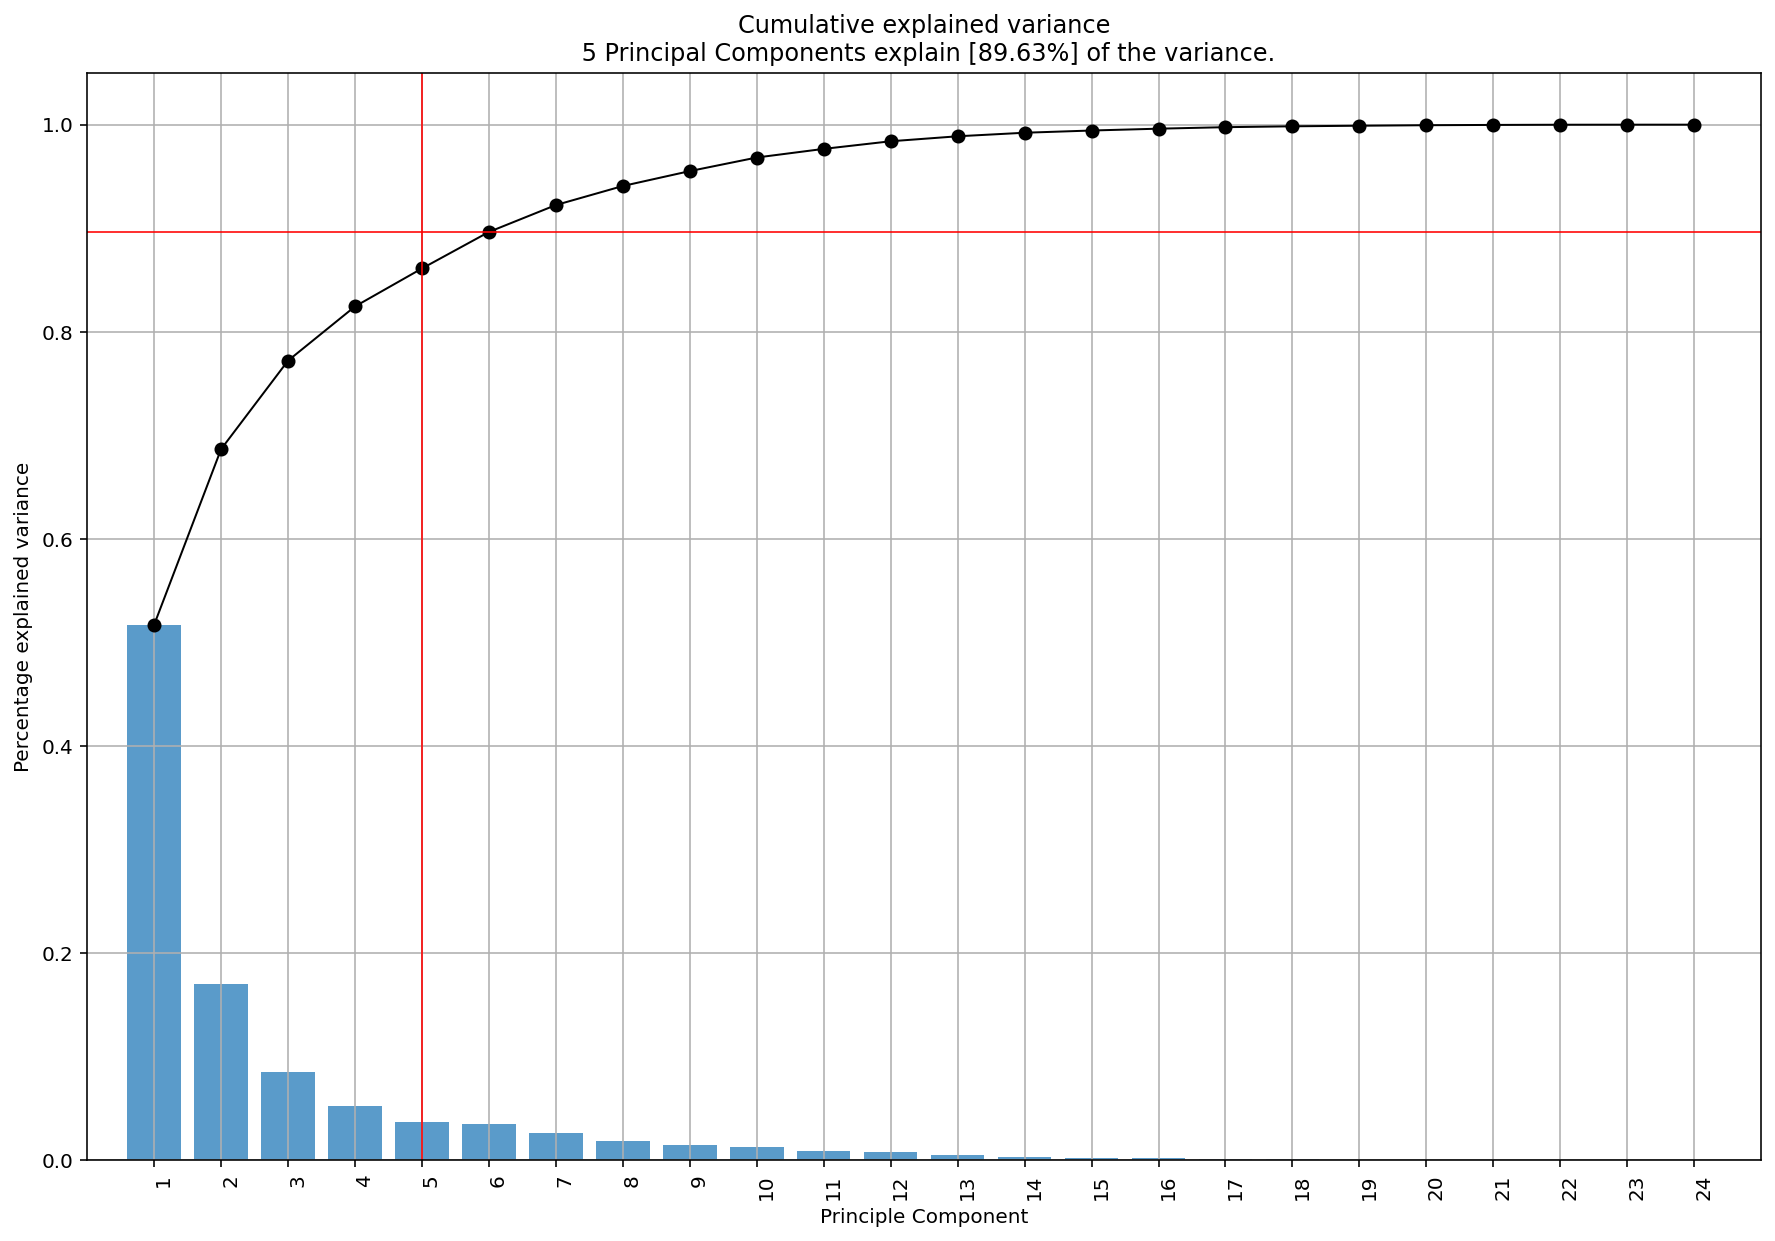

<Figure size 432x288 with 0 Axes>

In [7]:
model = models[0]
fig, ax = model.plot()
fig.savefig('figs/outputs/elbow.pdf', format='pdf')

In [5]:
from sklearn.preprocessing import scale


result = dataset.merged.obj.copy()
result[features] = scale(dataset.merged.obj[features])

dataset.add_item_from_dataframe(
    data=result,
    name='normalized_merged',
    description="Normalizing merged dataset.",
    rel_path_folder='processed',
    save=True,
)